## Null model and distributional model of Price-V3.0
* Eva Jin 
* 12th Dec, 2022
* Price baseline model for report

In [1]:
import duckdb

In [22]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

sns.set(style="whitegrid")

from pprint import pprint

In [3]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

### EDA-Price

The variable price that represents price per night charged for that listing in the database, is the target variable we interested to predict by other related covariates. Since Airbnb is an online community that provides short-term homestays and apartment rental at an amzing price, therefore, the price in database is expected to concentrate within the smaller charges and looks like positive skewed distribution.

In [5]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [14]:
price=pd.DataFrame(full_latest_listings.price)
price.describe()

,price
count,10560.000000
mean,198.181818
std,422.463628
min,0.000000
25%,85.000000
50%,129.000000
75%,206.000000
max,24999.000000


In [19]:
print("The rows of price over than $1000 is",len(price[price.price>1000]))
np.round(len(price[price.price>1000])/len(price)*100,3)# the ratio of price over than $1000 

The rows of price over than $1000 is 137


1.297

C:\Software\ANACONDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Software\ANACONDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Price($)')

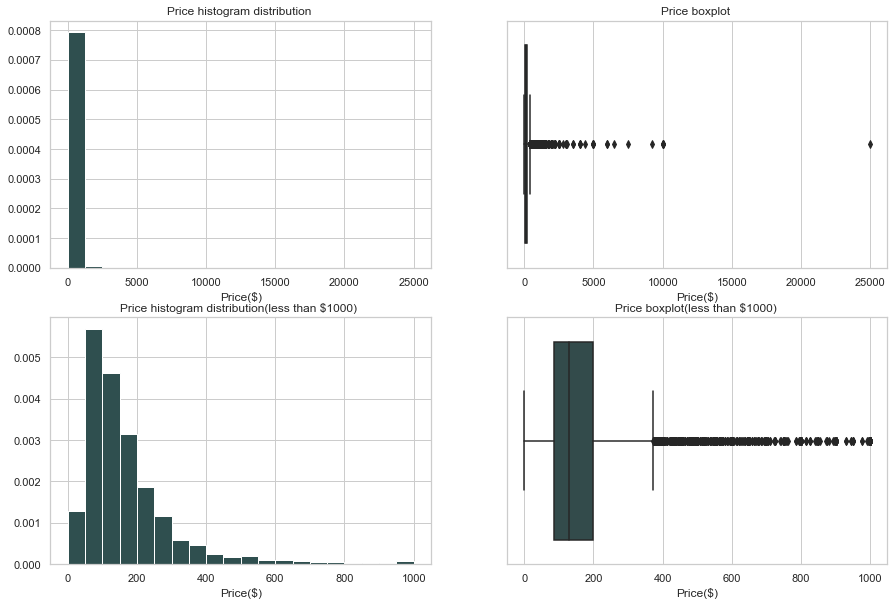

In [23]:
figure = plt.figure(figsize=(15,10))

axes = figure.add_subplot(2, 2, 1)
axes.hist(price,color="darkslategray",bins=20,density=True)
axes.set_title("Price histogram distribution ")
axes.set_xlabel("Price($)")

axes = figure.add_subplot(2, 2, 2)
sns.boxplot(np.array(price),color="darkslategray")
axes.set_title("Price boxplot ")
axes.set_xlabel("Price($)")


data_price=price[price.price<1001]
axes = figure.add_subplot(2, 2, 3)
axes.hist(data_price,color="darkslategray",bins=20,density=True)
axes.set_title("Price histogram distribution(less than $1000) ")
axes.set_xlabel("Price($)")

axes = figure.add_subplot(2, 2, 4)
sns.boxplot(np.array(data_price),color="darkslategray")
axes.set_title("Price boxplot(less than $1000) ")
axes.set_xlabel("Price($)")

According to the summary statistics of price and the distribution of price, it can be found that
* the deviation of price is large with the range of $\$$24,999(max-min), and the perception of price charged below $\$$ 1000 is 98.70$\%$ (100%-1.30%)of overall data
* the distribution of price is positively skewed sharply and most of price are concentrated within the range from $\$$50 to $\$$400.

### Story generation

As per the previous EDA and CLD analysis, there are many factors are estimated to influence the booked price in Airbnb.For instance, the room type, number of beds, property type, and apartment location are all the potential factores to decrease or increase the price of apartment rental. So price is likely to be the outcome of many independent variables affects some working to increase price and some working to decrease price. As a result, price is very likely to follow an approximate normal distribution.

However, since the deviation of price is large as 482, and the histogram shows the positive skewed distribution, we will try logarithmic transformation of price to fit the distribution model alternatively.

### Null (Mean) Model of price

We want to be able to predict price of a random booking. Our loss function will be MSE which means that over and under estimates are symmetric and large errors are penalized more than small errors. Because of this, we'll use the mean as our prediction:

In [24]:
price_mean=np.mean(data_price)
price_std=np.std(data_price)

In [25]:
price_mean

price    169.130673
dtype: float64

We predict that the price of a random booking will be $\$$171.05.

The 95% error bounds on that estimate are:

In [26]:
price_std

price    139.129992
dtype: float64

In [27]:
price_mean-1.96*price_std,price_mean+1.96*price_std

(price   -103.564112
 dtype: float64,
 price    441.825457
 dtype: float64)

Since the price cannot be negative, that is, we expect to see a range of values for price from 0 to $\$$441.82 about 95% percent of the time.

### Distributional model of price

As per the previous analysis, we first try Normal distribution to fit data.

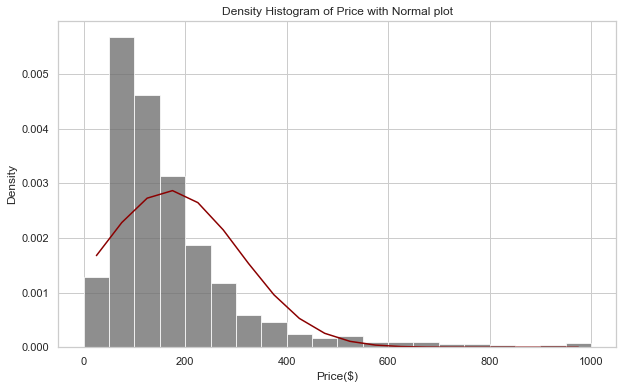

In [33]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(data_price, color="DimGray", density=True, bins=20, alpha=0.75)
axes.set_xlabel( "Price($)")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Price with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [norm.pdf( k, loc=price_mean, scale=price_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

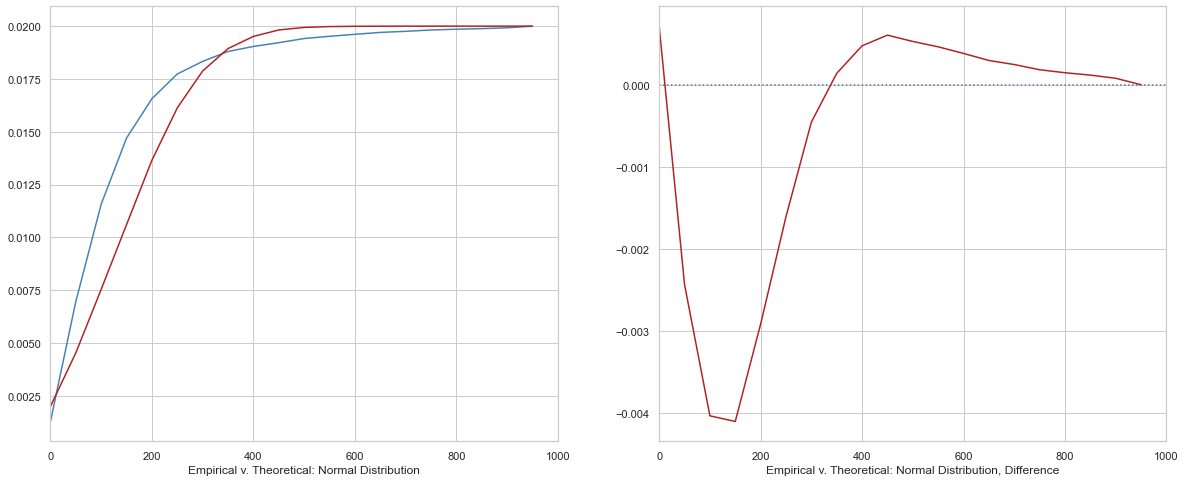

In [34]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(data_price)
price_mx = np.max(data_price)
mean = np.mean(data_price)
std = np.std(data_price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(data_price, bins=20, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((0, 1000))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((0, 1000))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((0, 1000))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

From above model analysis, we can see the Normal model is not a very perfect model for fitting the price data. The model will predict lower price below approximate $\$$350 and higher price over $\$$400. The largest discrepancies between empirical and theoretical difference are around $\$$100 to $\$$ 150 but they are very small.

### Null(Mean) Model of log(Price)

As mentioned in story generation part, since the deviation of price is large and the histogram shows the positive skewed distribution, we will try logarithmic transformation of price to fit Normal distribution model alternatively.

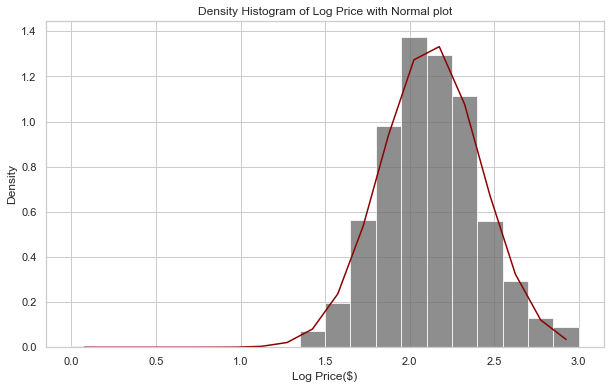

In [35]:
log_price=np.log10(data_price+1)#there are some free charged price, to avoid the infinite value, we add 1 to each price data
log_mean=np.mean(log_price)
log_std=np.std(log_price)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(log_price, color="DimGray", density=True, bins=20, alpha=0.75)
axes.set_xlabel( "Log Price($)")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Log Price with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [norm.pdf( k, loc=log_mean, scale=log_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

In [36]:
log_mean=np.mean(log_price)
log_std=np.std(log_price)

In [37]:
10**log_mean-1

price    132.786801
dtype: float64

We predict that the price of a random booking will be $\$$132.78.

The 95% error bounds on that estimate are:

In [38]:
log_std

price    0.295416
dtype: float64

In [39]:
10**(log_mean-1.96*log_std)-1,10**(log_mean+1.96*log_std)-1

(price    34.26937
 dtype: float64,
 price    506.491576
 dtype: float64)

The logarithmic transformation price estimation is more rational compared to the estimation by null model, that is, we expect to see a range of values for price from $\$$ 34.27 to $\$$506.49 about 95% percent of the time.

### Distribution model of log(Price)

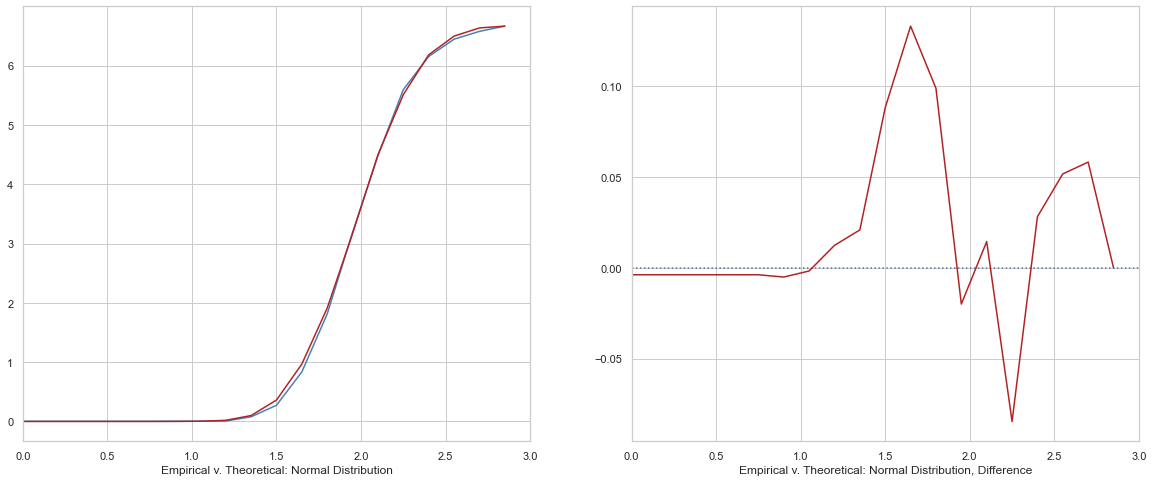

In [40]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(log_price)
price_mx = np.max(log_price)
mean = np.mean(log_price)
std = np.std(log_price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(log_price, bins=20, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((0, 3))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((0, 3))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((0, 3))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

The blue line (Normal distribution of Log Price) looks like a pretty good (smooth) approximation of the red line (Empirical distribution). The Normal distributional model with logarithmic transformation of price can fit the practical price data better compared to the previous model.

The largest discrepency is at $\$$ 50 (10<sup>1.7</sup>) approximately, the differences between fitted price and practical price mainly range from $\$$ 50 to $\$$ 200  (10<sup>2.3</sup>) according to the Normal Distribution Difference linechart.

What is the probability of the Price less than $\$$ 400 in Airbnb ?

In [53]:
norm.cdf(np.log10(400), log_mean, log_std)

array([0.94631097])

There is 94.6% probability of  a (random) price less than $\$$400 in Airbnb from the last quarter.

## Conclusion for Null model and Distributional model of Price

* Based on previous EDA and CLD analysis, we know price is likely to be the outcome of many independent variables affects some working to increase price and some working to decrease price. As per the domain knowledge, we assume price is very likely to follow an approximate normal distribution. 

* Two kinds of Null model(Mean model) and Distributional model are constructed by Price and logarithmic transformation of Price.

* Normal model of Price is not a very perfect model for fitting the price data. The model will predict lower price below approximate  $\$$ 350 and higher price over  $\$$ 400. The largest discrepancies between empirical and theoretical difference are around  $\$$ 100 to  $\$$  150.

* Normal distribution of Log Price looks like a pretty good approximation of the Empirical distribution. The Normal distributional model with logarithmic transformation of price can fit the practical price data better.

* Range of values for random booked price is from $\$$34.27 to $\$$506.49  about 95% percent of the time.

* The largest discrepency is at $\$$ 50 (10<sup>1.7</sup>) approximately, the differences between fitted price and practical price mainly range from $\$$ 50 to $\$$ 200  (10<sup>2.3</sup>) according to the Normal Distribution Difference linechart.
* We can predict that the probability of price less than $\$$ 400 booked in Airbnb from the last quarter is 94.6%

In [54]:
con.close()